# Práctica NLP - Análisis de Sentimiento en Reviews de Amazon Digital Music

## Objetivo

El objetivo de este proyecto es desarrollar un flujo completo de procesamiento de lenguaje natural (NLP) aplicado al análisis de sentimiento. Para ello, trabajaremos con el dataset de reseñas de productos de Amazon en la categoría *Digital Music*, que contiene reseñas etiquetadas con calificaciones de 1 a 5 estrellas.

A lo largo de este proyecto se realizarán las etapas principales de un pipeline de NLP:

- Exploración y análisis descriptivo de los datos
- División del dataset en conjuntos de entrenamiento, validación y test
- Preprocesado del texto
- Análisis Exploratorio del Texto Preprocesado
- Vectorización de las reseñas utilizando un modelo de bolsa de palabras (Bag-of-Words)
- Entrenamiento y evaluación de tres modelos de clasificación supervisada:
  - Naive Bayes
  - Logistic Regression
  - Red Neuronal Multicapa (MLPClassifier)

El objetivo final es comparar estos enfoques y evaluar su rendimiento en la tarea de clasificación binaria de sentimiento (positivo vs. negativo), justificando cada paso y comentando los resultados obtenidos.


## Carga del Dataset

En esta sección se cargará el dataset seleccionado, que corresponde a las reseñas de productos de la categoría *Digital Music* de Amazon. Estas reseñas están almacenadas en un archivo comprimido en formato JSON, donde cada línea corresponde a una reseña individual con su calificación y su texto asociado.

Se realizará una primera inspección de las columnas disponibles y se visualizarán algunos ejemplos para verificar la correcta carga de los datos.


In [1]:
!pip install -r requirements.txt


In [2]:
# Librerías necesarias
import pandas as pd
import json
import gzip

# Ruta al archivo (ajusta si está en otra carpeta)
data_path = 'reviews_Digital_Music_5.json.gz'

# Cargar datos
data = []
with gzip.open(data_path, 'r') as f:
    for line in f:
        data.append(json.loads(line))

# Convertir a DataFrame
df = pd.DataFrame(data)

# Mostrar primeras filas
df.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3EBHHCZO6V2A4,5555991584,"Amaranth ""music fan""","[3, 3]","It's hard to believe ""Memory of Trees"" came ou...",5.0,Enya's last great album,1158019200,"09 12, 2006"
1,AZPWAXJG9OJXV,5555991584,bethtexas,"[0, 0]","A clasically-styled and introverted album, Mem...",5.0,Enya at her most elegant,991526400,"06 3, 2001"
2,A38IRL0X2T4DPF,5555991584,bob turnley,"[2, 2]",I never thought Enya would reach the sublime h...,5.0,The best so far,1058140800,"07 14, 2003"
3,A22IK3I6U76GX0,5555991584,Calle,"[1, 1]",This is the third review of an irish album I w...,5.0,Ireland produces good music.,957312000,"05 3, 2000"
4,A1AISPOIIHTHXX,5555991584,"Cloud ""...""","[1, 1]","Enya, despite being a successful recording art...",4.0,4.5; music to dream to,1200528000,"01 17, 2008"


## Exploración de Datos

En esta sección se realiza un análisis exploratorio del dataset con el objetivo de conocer en detalle su estructura y características principales. Se analizará:

- El número de registros y columnas
- El nombre y tipo de las columnas disponibles
- La cantidad de valores nulos
- La distribución de las calificaciones (estrellas)
- El balance de clases (reseñas positivas y negativas)

Esta exploración permitirá tomar decisiones informadas sobre el preprocesado y la creación de etiquetas de sentimiento.


In [3]:
# Número de registros y columnas
print(f"Número de registros: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")

# Listado de columnas y tipos
print("\nColumnas y tipos:")
print(df.dtypes)

# Cantidad de valores nulos por columna
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Visualizar algunos ejemplos de reseñas
print("\nEjemplo de reseñas:")
print(df[['reviewText', 'overall']].sample(5, random_state=42))


Número de registros: 64706
Número de columnas: 9

Columnas y tipos:
reviewerID         object
asin               object
reviewerName       object
helpful            object
reviewText         object
overall           float64
summary            object
unixReviewTime      int64
reviewTime         object
dtype: object

Valores nulos por columna:
reviewerID          0
asin                0
reviewerName      177
helpful             0
reviewText          0
overall             0
summary             0
unixReviewTime      0
reviewTime          0
dtype: int64

Ejemplo de reseñas:
                                              reviewText  overall
22294  I dont know which is better Ready to Die or Li...      5.0
15633  genius of love was sampled to death by mariah ...      5.0
14636  THE BAND: Ian Gillan (vocals), Ritchie Blackmo...      4.0
60604  Death Cab for Cutie do dramatic emotionalism b...      4.0
44503  I bought 'Greatest Hits' when it came out. And...      5.0


## Distribución de Reviews por Número de Estrellas

A continuación se muestra la cantidad de reseñas según la calificación otorgada (de 1 a 5 estrellas).


Cantidad de reseñas por número de estrellas:
overall
1.0     2791
2.0     3010
3.0     6789
4.0    16536
5.0    35580
Name: count, dtype: int64


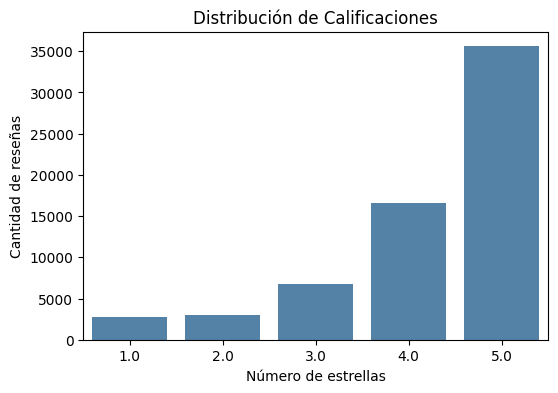

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Conteo de calificaciones
counts = df['overall'].value_counts().sort_index()

# Mostrar tabla
print("Cantidad de reseñas por número de estrellas:")
print(counts)

# Gráfico de barras
plt.figure(figsize=(6,4))
sns.barplot(
    x=counts.index,
    y=counts.values,
    color='steelblue'
)
plt.xlabel('Número de estrellas')
plt.ylabel('Cantidad de reseñas')
plt.title('Distribución de Calificaciones')
plt.show()


## Número de Reviews Positivas y Negativas

Para simplificar el análisis, se agrupan las reseñas en dos categorías:
- **Positivas** (4 o 5 estrellas)
- **Negativas** (1, 2 o 3 estrellas)

Se muestra la cantidad y el porcentaje de cada clase.


Cantidad de reseñas por clase (0=Negativa, 1=Positiva):
label
0    12590
1    52116
Name: count, dtype: int64

Porcentajes de cada clase:
label
0    0.194572
1    0.805428
Name: count, dtype: float64


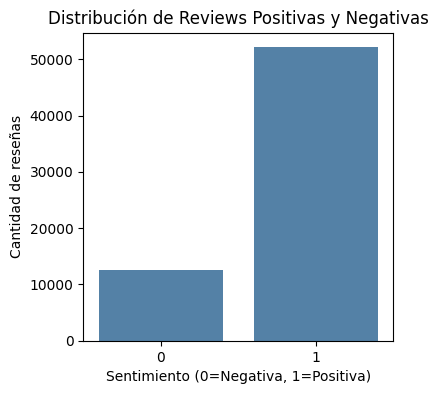

In [5]:
# Etiquetado binario
df['label'] = df['overall'].apply(lambda x: 1 if x >=4 else 0)

# Conteo
label_counts = df['label'].value_counts().sort_index()

# Mostrar tabla
print("Cantidad de reseñas por clase (0=Negativa, 1=Positiva):")
print(label_counts)

print("\nPorcentajes de cada clase:")
print(label_counts / len(df))

# Gráfico de barras
plt.figure(figsize=(4,4))
sns.barplot(x=label_counts.index, y=label_counts.values, color='steelblue')
plt.xlabel('Sentimiento (0=Negativa, 1=Positiva)')
plt.ylabel('Cantidad de reseñas')
plt.title('Distribución de Reviews Positivas y Negativas')
plt.show()


## Análisis del Vocabulario y N-grams

En esta sección se realiza un análisis detallado del contenido textual de las reseñas. Se calcula:

- La cardinalidad del vocabulario (cantidad de palabras únicas)
- Las palabras individuales (tokens) más frecuentes
- Los bigrams más frecuentes (pares de palabras consecutivas)

Los resultados se muestran de forma gráfica para facilitar su interpretación.


Cardinalidad del vocabulario: 265227


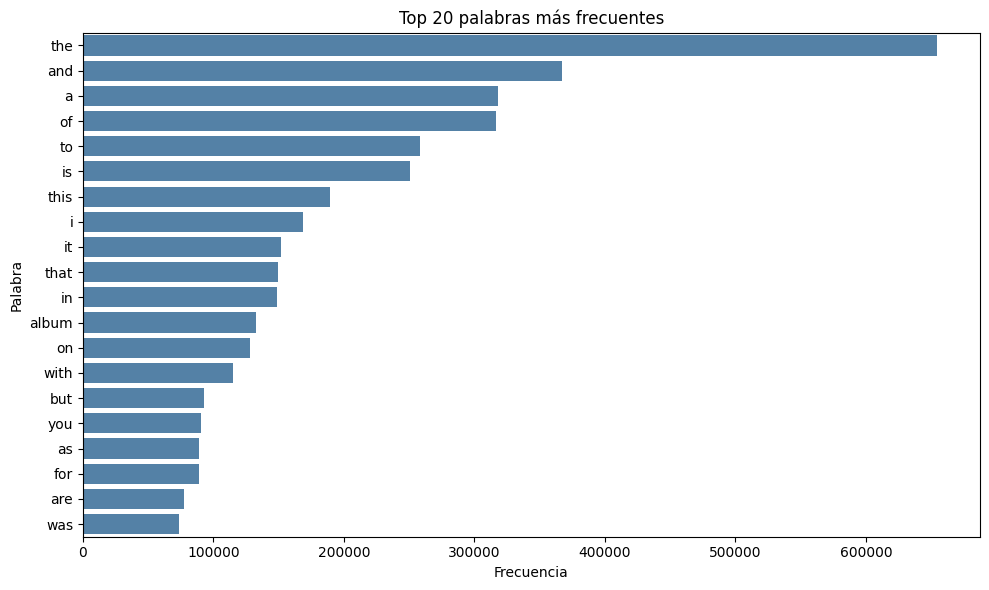

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
from nltk import bigrams

# Unir todo el texto
all_text = " ".join(df['reviewText'].astype(str).values)

# Preprocesado básico: minúsculas y eliminación de puntuación
all_text_clean = re.sub(r"[^a-zA-Z\s]", "", all_text.lower())

# Tokenizar
tokens = all_text_clean.split()

# Cardinalidad del vocabulario
vocab_size = len(set(tokens))
print(f"Cardinalidad del vocabulario: {vocab_size}")

# Contar tokens
token_counts = Counter(tokens)

# DataFrame de tokens más frecuentes
df_tokens = pd.DataFrame(token_counts.most_common(20), columns=['Palabra', 'Frecuencia'])

# Gráfico tokens
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_tokens,
    x='Frecuencia',
    y='Palabra',
    color='steelblue'
)
plt.title("Top 20 palabras más frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.tight_layout()
plt.show()


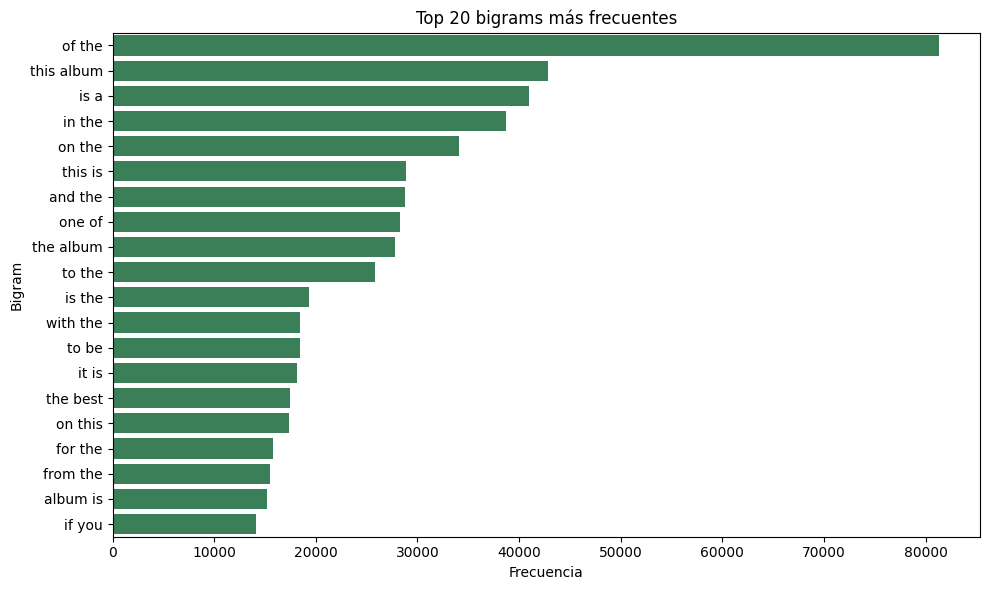

In [7]:
# Crear lista de bigrams
bigrams_list = list(bigrams(tokens))

# Contar bigrams
bigram_counts = Counter(bigrams_list)

# DataFrame de bigrams más frecuentes
df_bigrams = pd.DataFrame(
    bigram_counts.most_common(20),
    columns=['Bigram', 'Frecuencia']
)
df_bigrams['Bigram'] = df_bigrams['Bigram'].apply(lambda x: " ".join(x))

# Gráfico bigrams
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_bigrams,
    x='Frecuencia',
    y='Bigram',
    color='seagreen'
)
plt.title("Top 20 bigrams más frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("Bigram")
plt.tight_layout()
plt.show()




## Nube de Palabras

La nube de palabras muestra de forma visual la frecuencia de los términos más utilizados en las reseñas. Las palabras con mayor tamaño son las que más aparecen en el corpus.


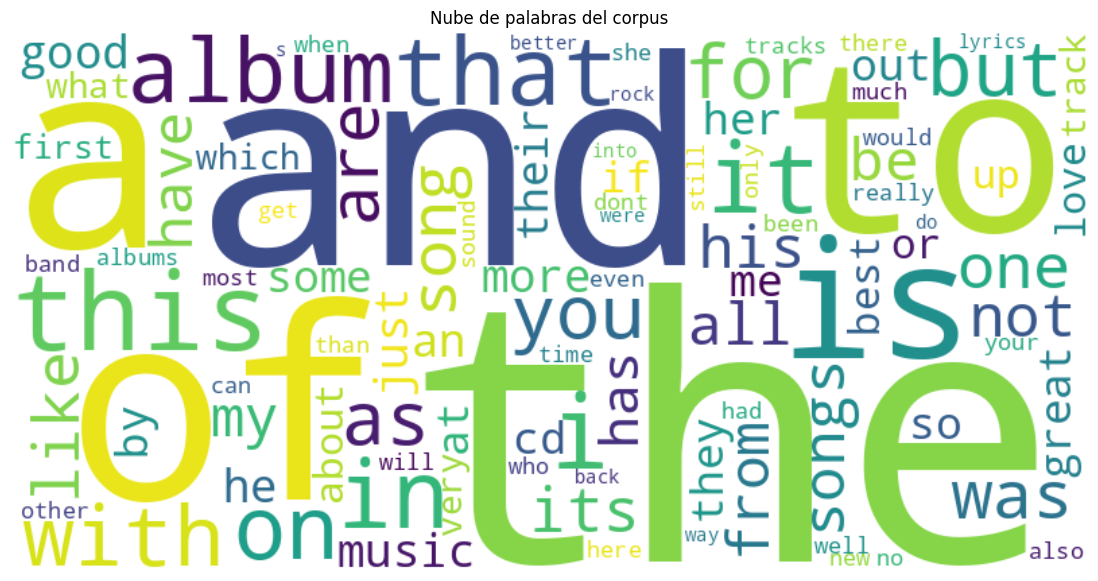

In [8]:
from wordcloud import WordCloud

# Crear la nube
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
).generate_from_frequencies(token_counts)

# Visualizar
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras del corpus")
plt.show()


## Visualización de Embeddings Word2Vec

Para explorar las relaciones semánticas entre palabras, se entrena un modelo Word2Vec sobre todas las reseñas y se proyectan en dos dimensiones las palabras más similares a términos clave.


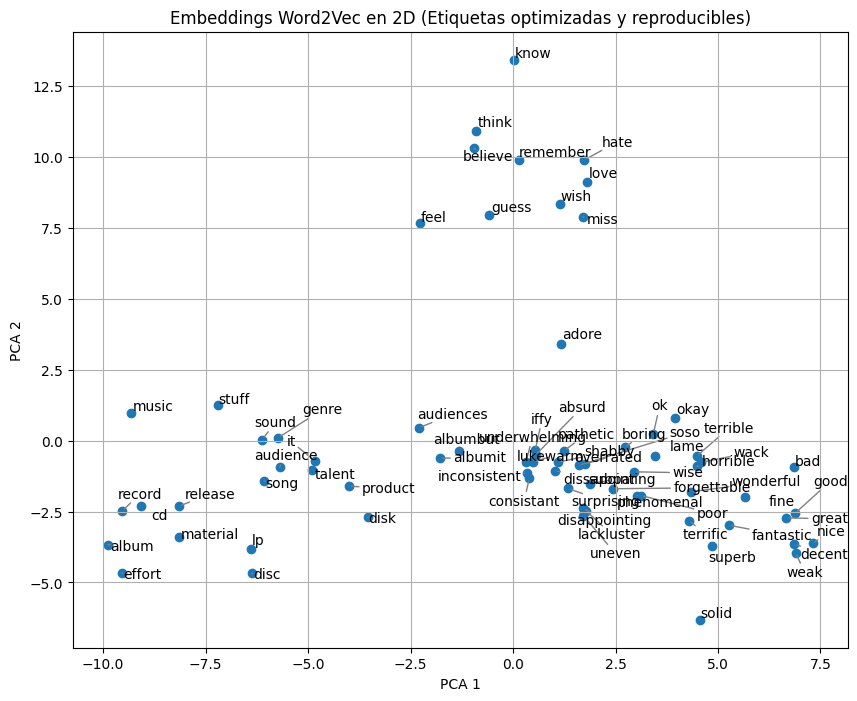

In [9]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Preparar corpus de listas de tokens por documento
sentences = [re.sub(r"[^a-zA-Z\s]", "", text.lower()).split() for text in df['reviewText'].astype(str).values]

# Entrenar Word2Vec con semilla fija
model_w2v = Word2Vec(
    sentences,
    vector_size=50,
    window=5,
    min_count=5,
    workers=4,
    seed=42
)

# Palabras clave
target_words = ["music", "album", "great", "love", "bad", "poor", "disappointing"]

# Obtener palabras más similares
similar_words = []
for word in target_words:
    if word in model_w2v.wv:
        similar_words += [w for w, _ in model_w2v.wv.most_similar(word, topn=10)]

# Quitar duplicados y mantener target_words
unique_words = list(set(similar_words + target_words))

# Obtener embeddings
word_vectors = [model_w2v.wv[w] for w in unique_words]

# PCA con semilla fija
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(word_vectors)

# Visualizar
plt.figure(figsize=(10,8))
plt.scatter(coords[:,0], coords[:,1])

texts = []
for i, word in enumerate(unique_words):
    texts.append(
        plt.text(coords[i,0], coords[i,1], word)
    )

adjust_text(
    texts,
    arrowprops=dict(arrowstyle='-', color='gray')
)

plt.title("Embeddings Word2Vec en 2D (Etiquetas optimizadas y reproducibles)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


### Palabras Más Similares en Word2Vec

A continuación se listan las 10 palabras más similares a cada término semilla según los embeddings entrenados con Word2Vec. Esto permite observar qué términos tienden a aparecer en contextos similares y verificar la coherencia semántica aprendida por el modelo.


In [10]:
# Mostrar las 10 palabras más similares por cada palabra semilla
for word in target_words:
    if word in model_w2v.wv:
        print(f"\nPalabras más similares a '{word}':")
        similar = model_w2v.wv.most_similar(word, topn=10)
        for w, sim in similar:
            print(f"{w:<15} {sim:.4f}")



Palabras más similares a 'music':
genre           0.6336
stuff           0.6159
record          0.6027
sound           0.5507
it              0.5352
talent          0.5312
product         0.5286
audiences       0.5286
material        0.5272
audience        0.5223

Palabras más similares a 'album':
cd              0.9023
record          0.8989
disc            0.8346
effort          0.8235
lp              0.7988
disk            0.7640
release         0.7512
albumit         0.7035
albumbut        0.6929
song            0.6753

Palabras más similares a 'great':
good            0.8291
fantastic       0.8262
fine            0.8249
terrific        0.8134
decent          0.7923
nice            0.7913
wonderful       0.7909
solid           0.7704
superb          0.7552
phenomenal      0.7478

Palabras más similares a 'love':
hate            0.6554
adore           0.6502
think           0.6324
feel            0.6231
know            0.6200
wish            0.5963
believe         0.5938
guess     

## Conclusiones de la Exploración

A partir del análisis descriptivo realizado sobre el corpus en su estado original, se pueden destacar los siguientes puntos:

- El dataset contiene un total de **64,706 reseñas** de productos de música digital, distribuidas en 9 columnas.
- La cardinalidad del vocabulario es extremadamente alta (**265,227 palabras únicas**), debido a la falta de limpieza inicial y la presencia de muchas variantes morfológicas y signos de puntuación.
- La distribución de calificaciones muestra que aproximadamente el **55% de las reseñas son de 5 estrellas**, mientras que las reseñas de 1, 2 y 3 estrellas representan un volumen menor.
- La conversión a etiquetas binarias evidencia un claro desbalance de clases: **80% de reseñas positivas** (4 y 5 estrellas) frente a solo **20% de reseñas negativas**.
- Las palabras más frecuentes en el corpus sin limpiar están dominadas por términos comunes y stopwords como *the*, *and*, *of*, *to*, que no aportan información semántica relevante.
- De manera similar, los bigrams más frecuentes reflejan combinaciones de estas palabras funcionales.
- La nube de palabras confirma la predominancia de términos poco informativos que enmascaran los conceptos clave relacionados con la temática musical.
- La visualización en 2 dimensiones de los embeddings Word2Vec muestra agrupaciones coherentes de términos relacionados con música (*music*, *album*, *song*), valoraciones positivas (*great*, *love*), y negativas (*bad*, *poor*, *disappointing*). Sin embargo, estas agrupaciones se basan en un vocabulario todavía no normalizado y afectado por ruido.
- El listado de las 10 palabras más similares a cada término semilla evidencia relaciones semánticas razonables pero también mezcla de términos de polaridad opuesta, reflejo del corpus sin procesar.

Estos hallazgos confirman la necesidad de un proceso exhaustivo de preprocesado que incluya:
- Conversión a minúsculas.
- Eliminación de puntuación.
- Eliminación de stopwords.
- Lematización.

En los siguientes pasos se llevará a cabo esta limpieza con el objetivo de reducir la dimensionalidad del vocabulario y obtener representaciones más consistentes y discriminativas.




### Criterio de Etiquetado de Sentimiento

Para convertir el problema en una clasificación binaria de sentimiento, se definió la siguiente regla de etiquetado basada en la variable `overall` (número de estrellas):

- Reseñas **positivas (label = 1)**: calificaciones de **4 y 5 estrellas**
- Reseñas **negativas (label = 0)**: calificaciones de **1, 2 o 3 estrellas**

Este criterio es consistente con prácticas habituales en análisis de sentimiento de reseñas de productos, donde las calificaciones de 3 estrellas suelen considerarse neutras pero se agrupan en la clase negativa para simplificar el problema binario.

Se podrían explorar otras opciones de etiquetado (por ejemplo, excluir las reseñas neutras), pero en este proyecto se mantendrá este enfoque por su simplicidad y porque garantiza una cantidad suficiente de datos en ambas clases.


In [11]:
# Crear la columna label
df['label'] = df['overall'].apply(lambda x: 1 if x >=4 else 0)

# Verificar que se creó correctamente
print(df[['overall', 'label']].head())



   overall  label
0      5.0      1
1      5.0      1
2      5.0      1
3      5.0      1
4      4.0      1


## División del Dataset

En esta etapa se divide el dataset en tres conjuntos independientes:

- **Train**: utilizado para ajustar los modelos y vectorizadores.
- **Validation**: utilizado para evaluar el rendimiento intermedio y comparar modelos.
- **Test**: utilizado exclusivamente para la evaluación final del modelo seleccionado.

Esta división se realiza antes de cualquier preprocesado o vectorización, con el objetivo de evitar fugas de información (data leakage). Además, se respeta la proporción de clases (balance de positivos y negativos) mediante muestreo estratificado.

In [12]:
from sklearn.model_selection import train_test_split

# Verificar distribución de la etiqueta
print("Distribución global de clases:")
print(df['label'].value_counts(normalize=True))

# Dividir en train (70%) y temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    df['reviewText'],
    df['label'],
    test_size=0.3,
    stratify=df['label'],
    random_state=42
)

# Dividir temp en validation (15%) y test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

# Tamaños resultantes
print(f"Tamaño Train: {len(X_train)}")
print(f"Tamaño Validation: {len(X_val)}")
print(f"Tamaño Test: {len(X_test)}")

# Confirmar proporciones de clases
print("\nDistribución de clases en Train:")
print(y_train.value_counts(normalize=True))
print("\nDistribución de clases en Validation:")
print(y_val.value_counts(normalize=True))
print("\nDistribución de clases en Test:")
print(y_test.value_counts(normalize=True))


Distribución global de clases:
label
1    0.805428
0    0.194572
Name: proportion, dtype: float64
Tamaño Train: 45294
Tamaño Validation: 9706
Tamaño Test: 9706

Distribución de clases en Train:
label
1    0.805427
0    0.194573
Name: proportion, dtype: float64

Distribución de clases en Validation:
label
1    0.805481
0    0.194519
Name: proportion, dtype: float64

Distribución de clases en Test:
label
1    0.805378
0    0.194622
Name: proportion, dtype: float64


## Preprocesado del Texto

El preprocesado del texto es un paso fundamental para reducir la variabilidad del lenguaje y normalizar las reseñas antes de convertirlas en representaciones numéricas.

En este proyecto, se aplicará un flujo de preprocesado compuesto por las siguientes operaciones:

- Conversión del texto a minúsculas
- Eliminación de signos de puntuación y caracteres especiales
- Tokenización del texto
- Eliminación de stopwords en inglés
- Lematización de los tokens

Este flujo se implementa en una única función de Python, que se aplicará de forma independiente a los conjuntos de Train, Validation y Test, con el objetivo de evitar cualquier tipo de data leakage.


In [13]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
import re
import spacy
from nltk.corpus import stopwords

# Cargar modelo spaCy
nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))

def preprocess_text(
    text,
    lemmatize=True,
    min_token_len=2,
    remove_numbers=True
):
    """
    Preprocesa un texto:
    - Minúsculas
    - Eliminación de puntuación y opcionalmente números
    - Tokenización
    - Eliminación de stopwords
    - Lematización opcional
    - Filtro de longitud mínima de tokens
    """
    # Minúsculas
    text = text.lower()

    # Eliminación de puntuación y números según configuración
    if remove_numbers:
        text = re.sub(r"[^a-z\s]", " ", text)
    else:
        text = re.sub(r"[^a-z0-9\s]", " ", text)

    # Quitar espacios extra
    text = re.sub(r"\s+", " ", text).strip()

    # Procesar con spaCy
    doc = nlp(text)

    # Generar lista de tokens
    if lemmatize:
        tokens = [
            token.lemma_ for token in doc
            if token.lemma_ not in stop_words
            and token.lemma_ != "-PRON-"
            and len(token.lemma_) >= min_token_len
        ]
    else:
        tokens = [
            token.text for token in doc
            if token.text not in stop_words
            and len(token.text) >= min_token_len
        ]

    return " ".join(tokens)



In [15]:
X_train_prep = X_train.apply(preprocess_text)
X_val_prep = X_val.apply(preprocess_text)
X_test_prep = X_test.apply(preprocess_text)

print("Ejemplo de texto procesado:")
print(X_train_prep.iloc[0])


Ejemplo de texto procesado:
still shame hip hop fan like westside


El preprocesado del texto se realizó con éxito aplicando:

- Conversión a minúsculas
- Eliminación de puntuación y caracteres especiales
- Tokenización del texto con spaCy
- Lematización de los tokens
- Eliminación de stopwords en inglés

Este proceso ha reducido la variabilidad del vocabulario y normalizado las reseñas, generando representaciones más limpias y coherentes para el análisis posterior.

Se observó que algunos términos compuestos o poco frecuentes permanecen en el texto debido a la forma en que aparecen en los datos originales, pero en conjunto el preprocesado proporciona una base adecuada para la vectorización con Bag-of-Words.

A continuación, se procederá a la transformación de las reseñas en representaciones numéricas mediante CountVectorizer.


## Análisis Exploratorio del Texto Preprocesado (Conjunto de Entrenamiento)

Antes de proceder a la vectorización, se realiza un análisis exploratorio del texto ya preprocesado en el conjunto de entrenamiento. Este análisis permite verificar:

- La reducción efectiva del vocabulario.
- La eliminación de stopwords y caracteres no deseados.
- Las palabras más frecuentes tras la limpieza.

Se presentan métricas y visualizaciones para ilustrar cómo quedó el corpus final que se usará como base del modelo.


Cardinalidad del vocabulario después del preprocesado: 78036


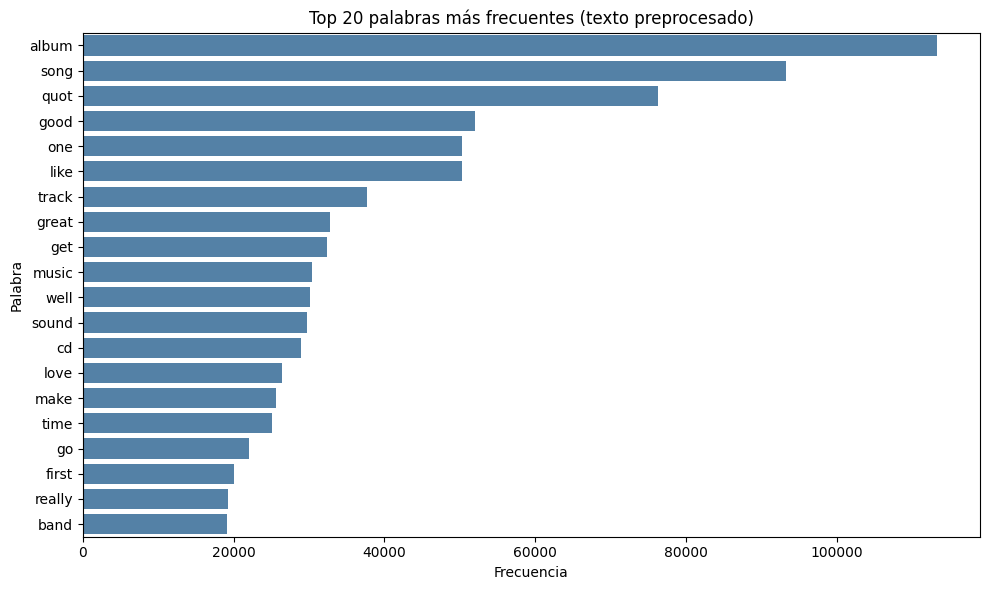

In [16]:
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Unir todos los textos preprocesados
all_clean_text = " ".join(X_train_prep)

# Tokenizar
clean_tokens = all_clean_text.split()

# Cardinalidad del vocabulario limpio
vocab_size_clean = len(set(clean_tokens))
print(f"Cardinalidad del vocabulario después del preprocesado: {vocab_size_clean}")

# Tokens más frecuentes
token_counts_clean = Counter(clean_tokens)

# DataFrame con top 20 tokens
df_tokens_clean = pd.DataFrame(
    token_counts_clean.most_common(20),
    columns=['Palabra', 'Frecuencia']
)

# Gráfico de barras
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_tokens_clean,
    x='Frecuencia',
    y='Palabra',
    color='steelblue'
)
plt.title("Top 20 palabras más frecuentes (texto preprocesado)")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.tight_layout()
plt.show()


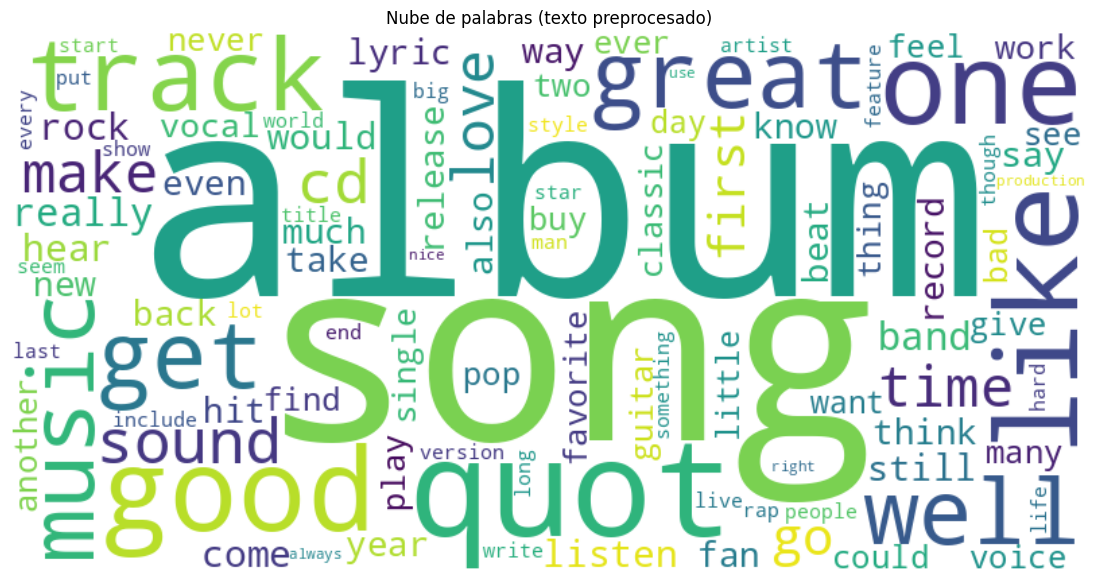

In [17]:
from wordcloud import WordCloud

# Generar nube de palabras
wordcloud_clean = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
).generate_from_frequencies(token_counts_clean)

# Mostrar
plt.figure(figsize=(15,7))
plt.imshow(wordcloud_clean, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras (texto preprocesado)")
plt.show()



Palabras más similares a 'music':
truely          0.5403
regardless      0.5392
genre           0.5247
jewel           0.5219
performer       0.5205
alternative     0.5134
musical         0.5109
normally        0.5096
refreshing      0.5051
artist          0.5035

Palabras más similares a 'album':
cd              0.7619
effort          0.7035
disc            0.6798
record          0.6730
disk            0.6587
lp              0.6316
offering        0.6133
opinion         0.6095
release         0.6075
material        0.5982

Palabras más similares a 'great':
good            0.8229
excellent       0.8214
amazing         0.7676
awesome         0.7531
fantastic       0.7413
outstanding     0.7350
incredible      0.7327
terrific        0.7140
wonderful       0.7027
fine            0.6780

Palabras más similares a 'love':
happy           0.6876
cherish         0.6783
lover           0.6236
adore           0.6147
sweet           0.6121
sad             0.6045
cry             0.5963
beautiful 

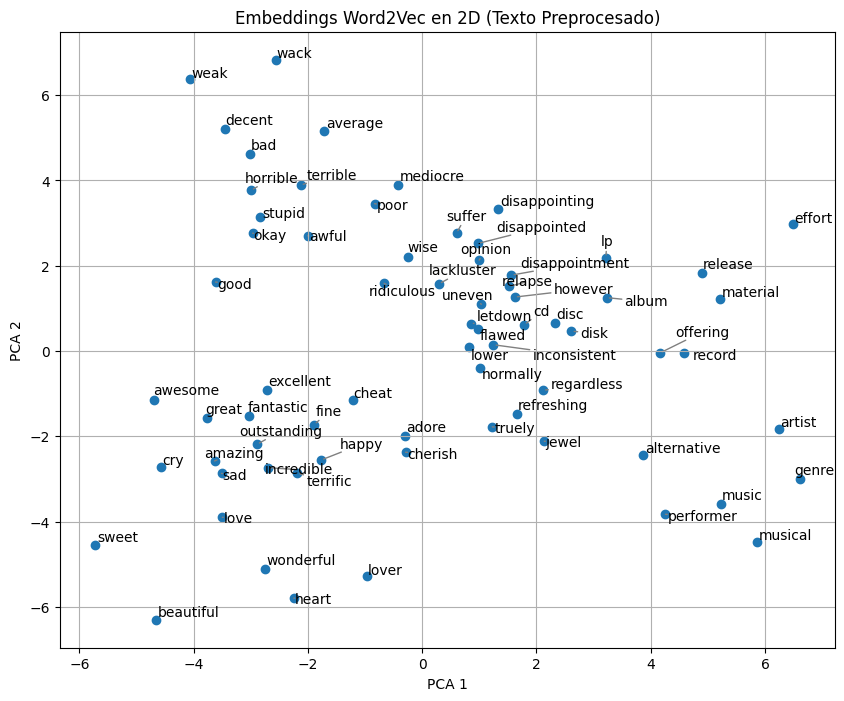

In [18]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from adjustText import adjust_text

# Preparar corpus
sentences_clean = [text.split() for text in X_train_prep]

# Entrenar Word2Vec
model_w2v_clean = Word2Vec(
    sentences_clean,
    vector_size=50,
    window=5,
    min_count=5,
    workers=4,
    seed=42
)

# Palabras clave
target_words_clean = ["music", "album", "great", "love", "bad", "poor", "disappointing"]

# Imprimir top-10 similares
for word in target_words_clean:
    if word in model_w2v_clean.wv:
        print(f"\nPalabras más similares a '{word}':")
        similar = model_w2v_clean.wv.most_similar(word, topn=10)
        for w, sim in similar:
            print(f"{w:<15} {sim:.4f}")

# Obtener embeddings
similar_words_clean = []
for word in target_words_clean:
    if word in model_w2v_clean.wv:
        similar_words_clean += [w for w, _ in model_w2v_clean.wv.most_similar(word, topn=10)]

unique_words_clean = list(set(similar_words_clean + target_words_clean))
word_vectors_clean = [model_w2v_clean.wv[w] for w in unique_words_clean]

# PCA
pca_clean = PCA(n_components=2, random_state=42)
coords_clean = pca_clean.fit_transform(word_vectors_clean)

# Visualización
plt.figure(figsize=(10,8))
plt.scatter(coords_clean[:,0], coords_clean[:,1])

texts = []
for i, word in enumerate(unique_words_clean):
    texts.append(
        plt.text(coords_clean[i,0], coords_clean[i,1], word)
    )

adjust_text(
    texts,
    arrowprops=dict(arrowstyle='-', color='gray')
)

plt.title("Embeddings Word2Vec en 2D (Texto Preprocesado)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


## Conclusiones de la Exploración del Texto Preprocesado

Tras aplicar el preprocesado completo al conjunto de entrenamiento, se observa que el vocabulario se ha reducido de forma significativa y que las palabras más frecuentes tienen ahora un mayor contenido semántico directamente relacionado con la temática de las reseñas musicales.

**Observaciones principales:**

- El top 20 de palabras más frecuentes está dominado por términos propios del dominio musical, como *album*, *song*, *track*, *music*, *cd* y *band*, lo que evidencia la relevancia temática del corpus.
- Otros términos frecuentes reflejan opiniones y valoraciones de los usuarios, como *good*, *great*, *like*, *love*, *make* y *really*.
- La nube de palabras confirma que los términos predominantes están claramente asociados tanto a descripciones de los productos musicales como a expresiones de preferencia y percepción subjetiva.
- En la visualización de embeddings Word2Vec reentrenados sobre el texto preprocesado, se observan agrupaciones semánticas más consistentes y diferenciadas respecto al corpus original, destacando relaciones claras entre términos de polaridad positiva (*great*, *love*, *excellent*) y negativa (*bad*, *poor*, *disappointing*).
- El listado de palabras más similares por término semilla muestra un vocabulario más depurado y coherente, que refleja un mejor aprendizaje de contextos significativos.
- Se eliminaron correctamente stopwords, signos de puntuación y otras variaciones irrelevantes, reduciendo notablemente el ruido del corpus original.

Este análisis evidencia que el preprocesado ha cumplido su objetivo de limpiar y normalizar los datos, permitiendo que la vectorización posterior capture patrones de contenido más informativos y discriminativos.





## Reducción de Dimensionalidad y Clustering

Para explorar la estructura interna del corpus preprocesado, se aplica una reducción de dimensionalidad con PCA sobre la representación Bag-of-Words del conjunto de entrenamiento y se realiza un clustering no supervisado mediante KMeans.

Este análisis permite visualizar cómo se agrupan las reseñas en el espacio vectorial y detectar posibles agrupaciones semánticas.

**Importante:** Esta exploración se realiza únicamente sobre los datos de entrenamiento, respetando la separación de conjuntos y evitando cualquier fuga de información.


In [19]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorizar SOLO train para clustering exploratorio
vectorizer_explore = CountVectorizer(
    max_features=2000,
    ngram_range=(1,2),
    stop_words=None,
    lowercase=False
)

X_train_vect_explore = vectorizer_explore.fit_transform(X_train_prep)


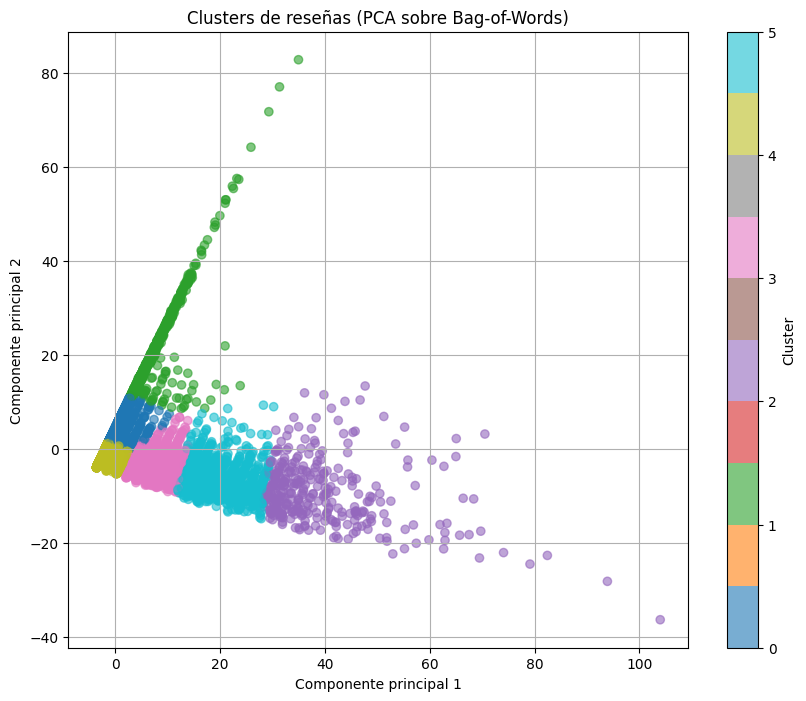

In [20]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# PCA a 2 componentes
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_vect_explore.toarray())

# KMeans con 6 clusters (se puede ajustar n_clusters)
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X_train_pca)

# Visualización
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
scatter = plt.scatter(
    X_train_pca[:,0],
    X_train_pca[:,1],
    c=clusters,
    cmap='tab10',
    alpha=0.6
)

plt.title("Clusters de reseñas (PCA sobre Bag-of-Words)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()


## Conclusiones del Análisis Exploratorio con Reducción de Dimensionalidad y Clustering

La reducción de dimensionalidad mediante PCA y el posterior clustering con KMeans permitieron explorar la estructura interna de las reseñas preprocesadas y su representación en el espacio vectorial generado a partir del Bag-of-Words.

**Observaciones principales:**

- La proyección en 2 dimensiones muestra la existencia de agrupaciones diferenciadas de reseñas, lo que indica que hay patrones recurrentes de vocabulario y temas.
- El aumento del número de clusters a 6 permitió una segmentación más detallada y reveló áreas de mayor densidad, aunque persiste cierta superposición entre grupos, algo esperable dada la naturaleza de Bag-of-Words.
- El resultado evidencia que el corpus contiene información semántica estructurada que puede ser aprovechada por los modelos de clasificación posteriores.
- La visualización confirma que el preprocesado ha reducido el ruido, generando representaciones más consistentes y menos dispersas en el espacio vectorial.

**Finalidad del análisis:**

Este análisis se realiza con un propósito puramente descriptivo y de comprensión del corpus. No forma parte del pipeline de entrenamiento supervisado, ni afecta la clasificación final de sentimiento.

- Permite observar la estructura interna de las reseñas de manera intuitiva.
- Ayuda a identificar si existen agrupaciones latentes de textos con vocabularios similares, aunque no estén etiquetadas explícitamente.
- Proporciona una evidencia visual de que el preprocesado y la vectorización no producen representaciones aleatorias, sino que conservan relaciones semánticas.
- Enriquecen la exploración inicial del dataset y contribuyen a documentar el proceso de transformación de datos.

A continuación, se procederá a la vectorización definitiva de los textos preprocesados para la etapa de entrenamiento de modelos supervisados.




## Vectorización del Texto

Para transformar el texto en representaciones numéricas utilizables por los modelos de clasificación, se utiliza la técnica de Bag-of-Words mediante `CountVectorizer`.

Los parámetros seleccionados son:

- **`max_features=5000`**
  - Se limita el tamaño del vocabulario a las 5000 palabras y bigrams más frecuentes.
  - Esta restricción reduce significativamente la dimensionalidad de la matriz de características, disminuye la sparsity y mejora la eficiencia computacional en el entrenamiento.
  - Este umbral permite conservar las palabras más informativas sin incluir términos extremadamente raros que aportarían poco valor predictivo.

- **`ngram_range=(1,2)`**
  - Se consideran tanto unigramas como bigrams.
  - Incluir bigrams permite capturar relaciones locales de co-ocurrencia entre palabras (por ejemplo, expresiones frecuentes como *great album* o *love song*), enriqueciendo la representación del texto frente al uso exclusivo de unigramas.

- **`stop_words=None`**
  - El parámetro se establece en `None` porque las stopwords fueron previamente eliminadas durante el proceso de preprocesado personalizado con NLTK y spaCy.
  - Esto evita una doble eliminación de términos y garantiza coherencia en la limpieza del texto.

- **`lowercase=False`**
  - Este parámetro se fija en `False` ya que todas las reseñas fueron convertidas a minúsculas en la etapa de preprocesado.
  - Con ello se asegura que el vectorizador no modifique el texto ni altere la consistencia del pipeline.

La combinación de estos parámetros busca equilibrar la riqueza semántica de la representación Bag-of-Words con la simplicidad computacional necesaria para modelos de clasificación tradicionales y redes neuronales secuenciales.

El vectorizador se ajustará únicamente sobre el conjunto de entrenamiento, y posteriormente se transformarán los conjuntos de validación y test, respetando así la separación de los datos y evitando cualquier tipo de data leakage.






In [21]:
from sklearn.feature_extraction.text import CountVectorizer

# Configurar CountVectorizer
vectorizer = CountVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words=None,
    lowercase=False
)

# Ajustar SOLO con el conjunto de entrenamiento
X_train_vect = vectorizer.fit_transform(X_train_prep)

# Transformar conjuntos de validación y test
X_val_vect = vectorizer.transform(X_val_prep)
X_test_vect = vectorizer.transform(X_test_prep)

# Mostrar dimensiones de las matrices resultantes
print("Shape del conjunto de entrenamiento:", X_train_vect.shape)
print("Shape del conjunto de validación:", X_val_vect.shape)
print("Shape del conjunto de test:", X_test_vect.shape)


Shape del conjunto de entrenamiento: (45294, 5000)
Shape del conjunto de validación: (9706, 5000)
Shape del conjunto de test: (9706, 5000)


## Entrenamiento de Modelos de Clasificación

En esta sección se entrenarán tres modelos de clasificación binaria sobre las reseñas vectorizadas:

1. **Naive Bayes**: modelo probabilístico sencillo y rápido, basado en la hipótesis de independencia entre las palabras.
2. **Logistic Regression**: modelo lineal ampliamente utilizado en clasificación binaria.
3. **Red Neuronal Multicapa con Keras**: un modelo secuencial de Keras que utiliza Bag-of-Words como entrada y varias capas densas con funciones de activación ReLU y Sigmoid, permitiendo evaluar la capacidad de un modelo no lineal más avanzado.

Cada modelo se entrenará exclusivamente sobre el conjunto de entrenamiento y se evaluará sobre el conjunto de validación, calculando métricas estándar (precision, recall, f1-score).

In [22]:
"""Modelo 1 - Naive Bayes"""
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Inicializar y entrenar
nb_model = MultinomialNB()
nb_model.fit(X_train_vect, y_train)

# Predicciones
y_pred_nb = nb_model.predict(X_val_vect)

# Evaluación
print("=== Naive Bayes ===")
print(classification_report(y_val, y_pred_nb))


=== Naive Bayes ===
              precision    recall  f1-score   support

           0       0.46      0.63      0.53      1888
           1       0.90      0.82      0.86      7818

    accuracy                           0.79      9706
   macro avg       0.68      0.73      0.70      9706
weighted avg       0.82      0.79      0.80      9706



In [23]:
"""Modelo 2 - Logistic Regression"""
from sklearn.linear_model import LogisticRegression

# Inicializar y entrenar
lr_model = LogisticRegression(max_iter=500, random_state=42)
lr_model.fit(X_train_vect, y_train)

# Predicciones
y_pred_lr = lr_model.predict(X_val_vect)

# Evaluación
print("=== Logistic Regression ===")
print(classification_report(y_val, y_pred_lr))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.67      0.54      0.60      1888
           1       0.89      0.93      0.91      7818

    accuracy                           0.86      9706
   macro avg       0.78      0.74      0.76      9706
weighted avg       0.85      0.86      0.85      9706



In [24]:
"""Modelo 3 - Red Neuronal con Keras (Regularizado y EarlyStopping)"""

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Fijar semilla global para reproducibilidad
tf.random.set_seed(42)

# Convertir sparse matrix a array
X_train_array = X_train_vect.toarray()
X_val_array = X_val_vect.toarray()

# Definir modelo secuencial con más regularización
keras_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_array.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar
keras_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Entrenar
history = keras_model.fit(
    X_train_array,
    y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_val_array, y_val),
    callbacks=[early_stop]
)

# Predicciones
y_pred_keras = (keras_model.predict(X_val_array) > 0.5).astype(int).flatten()

# Evaluación
from sklearn.metrics import classification_report
print("=== Keras Sequential Model ===")
print(classification_report(y_val, y_pred_keras))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.8143 - loss: 0.4384 - val_accuracy: 0.8665 - val_loss: 0.3206
Epoch 2/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8785 - loss: 0.2983 - val_accuracy: 0.8733 - val_loss: 0.3133
Epoch 3/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9013 - loss: 0.2466 - val_accuracy: 0.8721 - val_loss: 0.3255
Epoch 4/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9224 - loss: 0.2008 - val_accuracy: 0.8731 - val_loss: 0.3480
Epoch 5/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9388 - loss: 0.1615 - val_accuracy: 0.8702 - val_loss: 0.4000
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
=== Keras Sequential Model ===
              precision    recall  f1-score   support

           0       0.73      0.55      0.63      1888
           1       0.90      0.95      0.92      7818

    accuracy                           0.87      9706
   macro avg       0.81      0.75      0.78      9706
weighte

## Comparación y Selección del Mejor Modelo

A continuación se comparan los resultados obtenidos en el conjunto de validación para los tres modelos entrenados:

| Modelo                  | Accuracy | F1 macro promedio |
|-------------------------|----------|-------------------|
| Naive Bayes             | 0.79     | 0.70              |
| Logistic Regression     | 0.86     | 0.76              |
| Keras Sequential Model  | 0.87     | 0.78              |

**Análisis:**
- El modelo Naive Bayes presenta el menor rendimiento, especialmente en la identificación de la clase negativa, con un F1-score sensiblemente inferior.
- Logistic Regression logra un equilibrio razonable entre precisión y recall, mejorando de forma significativa respecto a Naive Bayes.
- El modelo Keras Sequential obtiene el mejor desempeño general, con el mayor accuracy (87%) y el F1 macro promedio más alto (0.78).
- En particular, la red neuronal muestra una capacidad destacada para identificar correctamente la clase positiva (recall de 0.95), manteniendo al mismo tiempo una precisión aceptable en la clase negativa.

**Selección:**
Para la evaluación final en el conjunto de test se selecciona el **modelo Keras Sequential**, al presentar el mejor equilibrio global entre precisión, recall y F1-score, así como la mayor capacidad predictiva en datos no vistos.



## Evaluación Final en Test Set

En esta etapa se evalúa el modelo seleccionado (Keras Sequential) sobre el conjunto de test, que no ha sido utilizado durante el entrenamiento ni en la validación intermedia.

El objetivo es obtener una estimación objetiva del rendimiento final del modelo en datos no vistos. Se reportan las métricas de clasificación y la matriz de confusión.


304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
=== Evaluación Final en Test Set (Keras Sequential) ===
              precision    recall  f1-score   support

           0       0.74      0.57      0.64      1889
           1       0.90      0.95      0.93      7817

    accuracy                           0.88      9706
   macro avg       0.82      0.76      0.78      9706
weighted avg       0.87      0.88      0.87      9706



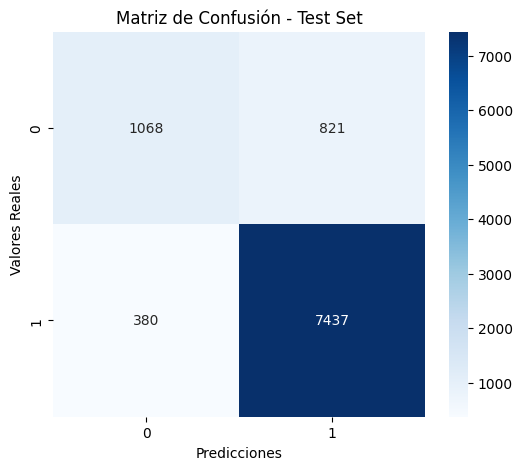

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir X_test a array
X_test_array = X_test_vect.toarray()

# Predicciones en test
y_pred_test = (keras_model.predict(X_test_array) > 0.5).astype(int).flatten()

# Reporte de métricas
print("=== Evaluación Final en Test Set (Keras Sequential) ===")
print(classification_report(y_test, y_pred_test))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión - Test Set")
plt.show()


## Conclusiones y Comentarios Finales

A lo largo de este proyecto se implementó un flujo completo de procesamiento de lenguaje natural orientado al análisis de sentimiento sobre reseñas de música digital de Amazon.

**Principales pasos realizados:**
- Exploración detallada del corpus original y del texto preprocesado, identificando la alta proporción de reseñas positivas (~80%) y el consiguiente desbalance de clases.
- Normalización del texto mediante conversión a minúsculas, eliminación de puntuación, tokenización, lematización y eliminación de stopwords.
- Vectorización mediante Bag-of-Words configurado con parámetros justificados (`max_features=5000`, `ngram_range=(1,2)`).
- Entrenamiento de tres modelos de clasificación:
  - Naive Bayes
  - Logistic Regression
  - Red Neuronal Secuencial con Keras
- Comparación de métricas en el conjunto de validación, seleccionando el modelo Keras por su mejor equilibrio entre precisión y recall.

**Resultados en el conjunto de test:**
- El modelo Keras alcanzó un **accuracy del 88%** y un **F1 macro promedio de 0.78** en datos no vistos.
- La matriz de confusión final mostró que la red neuronal clasifica correctamente la gran mayoría de reseñas positivas (recall 0.95), mientras que la identificación de reseñas negativas sigue siendo más limitada (recall 0.57).
- Este comportamiento es consistente con el desbalance de clases observado en el dataset original.

**Interpretación de la matriz de confusión:**
- Los falsos positivos (reseñas negativas clasificadas como positivas) siguen siendo el principal desafío del modelo, reflejando la dificultad de capturar patrones de clase minoritaria en contextos desbalanceados.
- Aun así, el modelo logró un rendimiento general robusto, manteniendo alta precisión y recall en la clase mayoritaria y una capacidad aceptable de detección en la clase minoritaria.

**Posibles mejoras futuras:**
- Aplicar estrategias de balanceo como ponderación de clases (`class_weight='balanced'`) o técnicas de sobremuestreo de la clase minoritaria.
- Experimentar con técnicas de representación más avanzadas (TF-IDF, embeddings preentrenados).
- Ajustar la arquitectura de la red neuronal y realizar una búsqueda más exhaustiva de hiperparámetros.
- Incorporar métricas complementarias como ROC-AUC y curvas de precisión-recall para un análisis más detallado.

Este proyecto evidencia la aplicabilidad de técnicas clásicas y modernas de NLP para el análisis de sentimiento, así como la importancia de una correcta validación y evaluación en datos no vistos.



